# 32x32 expGP image reconstruction

Image reconstruction.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch import nn

import swyft
import pylab as plt
import scipy.stats.distributions as dist

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class PowerSampler:
    def __init__(self, N, boxlength = 1.0):
        self.N = N
        d = boxlength/N
        freq = torch.fft.fftfreq(N, d=d)
        kx, ky = torch.meshgrid(freq, freq)
        k = (kx**2+ky**2)**0.5
        self.k = k + k[0,1]  # Offset to avoid singularities

    def sample(self, pk):
        N = self.N
        A = torch.randn(N,N)+1j*torch.randn(N,N)  # Random complex amplitudes
        phi_k = A*pk(self.k)
        phi_x = torch.fft.ifft2(phi_k)
        return phi_x.real

In [51]:
class SimulatorBlob(swyft.Simulator):
    def __init__(self, bounds = None, Npix = 64, sigma = 0.1):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.theta_sampler = swyft.RectBoundSampler([dist.uniform(2., 0.1)])
        self.bounds = bounds
        self.Npix = Npix
        self.sigma = sigma
        self.powersampler = PowerSampler(Npix)
            
    def build(self, graph):
        theta = graph.node("alpha", self.theta_sampler)
        delta = graph.node("delta", lambda theta: self.powersampler.sample(lambda k: 3*(k/0.5)**-theta[0]), theta)
        rho = graph.node("rho", lambda delta: torch.exp(3e3*delta), delta)
        rho = graph.node("x", lambda rho: rho + torch.randn(self.Npix, self.Npix)*0.01, rho)

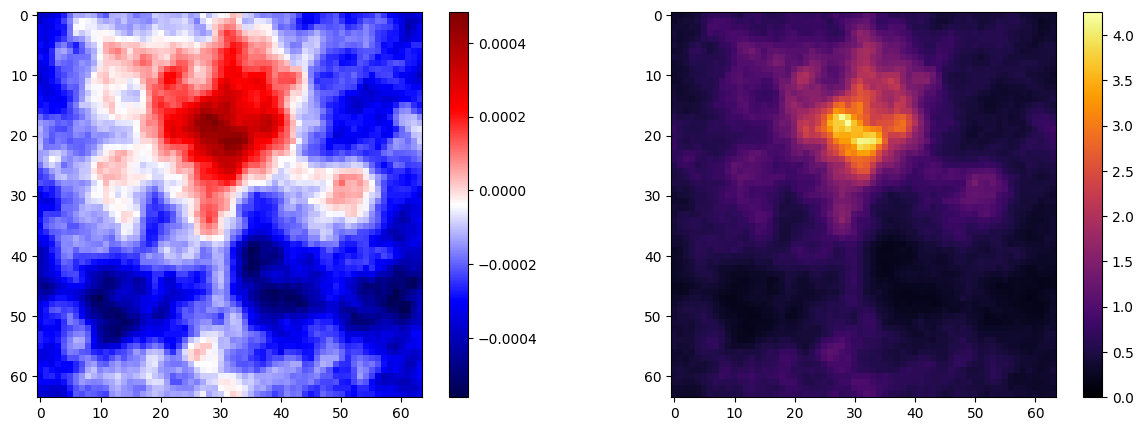

In [52]:
NPIX = 64
sim = SimulatorBlob(Npix = NPIX)
sample0 = sim.sample()
plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.imshow(sample0['delta'], cmap = 'seismic')
plt.colorbar()
plt.subplot(122)
plt.imshow(sample0['x'], cmap = 'inferno', vmin = 0)
plt.colorbar()

In [88]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3, N = 1024):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-3, lrs_factor=0.1, lrs_patience=3)
        self.N = N
        Phi = lambda x: x
        L = lambda x: x
        self.lre = swyft.LogRatioEstimator_Gaussian_Autoregressive_X(self.N**2, "mu", Phi_module = Phi, L_module = L, minstd = 1e-3)
        self.l = torch.nn.LazyLinear(1)

    def forward(self, A, B):
        N = self.N
        rhoA = A['x'].view(-1, N**2)
        rhoA = rhoA + 0*self.l(rhoA)
        rhoB = B['x'].view(-1, N**2)
        deltaB = B['delta'].view(-1, N**2)*1e3
        result = self.lre(rhoA, rhoB, deltaB)
        return result

In [89]:
sim = SimulatorBlob(Npix = NPIX)
samples = sim.sample(1000)
dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 64)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1991.77it/s]


In [90]:
net = Network(N = NPIX)

In [91]:
trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = 1, max_epochs = 5)
trainer.fit(net, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                        | Params
---------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Gaussian_Autoregressive_X | 0     
1 | l    | LazyLinear                                  | 0     
---------------------------------------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)


Epoch 0:  88%|███████████████████████████████████████████████████████████████████████████▉          | 15/17 [00:00<00:00, 32.27it/s, loss=-7.04e+03, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1:  88%|████████████████████████████████████████████████████████████        | 15/17 [00:00<00:00, 34.53it/s, loss=-7.17e+03, v_num=11, val_loss=-7.3e+3]
Validation: 0it [00:00, ?it/s]
Epoch 2:  88%|███████████████████████████████████████████████████████████        | 15/17 [00:00<00:00, 31.61it/s, loss=-7.24e+03, v_num=11, val_loss=-7.27e+3]
Validation: 0it [00:00, ?it/s]
Epoch 3:  88%|███████████████████████████████████████████████████████████        | 15/17 [00:00<00:00, 39.78it/s, loss=-7.29e+03, v_num=11, val_loss=-7.23e+3]
Validation: 0it [00:00, ?it/s]
Epoch 4:  88%|███████████████████████████████████████████████████████████        | 15/17 [00:00<00:00, 41.59it/s, loss=-7.32e+03, v_num=11, val_loss=-7.17e+3]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|████████████████████████████████████

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 38.82it/s, loss=-7.32e+03, v_num=11, val_loss=-7.1e+3]


In [1644]:
N = 1024
p = PowerSampler(N)
k = p.k
D2 = (1/k**2.5).view(N*N).double().cuda()
D2 = 0.0001/D2

In [1645]:
#L = torch.zeros(N*N, N*N).cuda().double()
#dd = torch.ones(N*N)
#dd[:N*N//2] = 0
#L = torch.diag(dd).cuda().double()
#for i in range(N):
#    j, k = i//8, i%8
#    print(j, k)
#    L[i,j:j+1,k:k+1] = 1.
#L = L.view(-1, N*N)
#G1 = lambda x: torch.matmul(L, x)
G1 = lambda x: x
D1 = torch.ones(N*N).cuda().double()*1
D1[:N*N//2] = 0.001
#G1T = lambda x: torch.matmul(L.T, x)
G1T = lambda x: x
U2 = lambda x: torch.fft.fft2(x.view(N, N), norm = 'ortho').view(N*N)
U2T = lambda x: torch.fft.ifft2(x.view(N, N), norm = 'ortho').view(N*N)
geda = GEDA(1e0, G1, D1, G1T, U2, D2, U2T)

In [1646]:
import tqdm.auto as tqdm

In [1647]:
x = geda.sample(16, steps = 100)

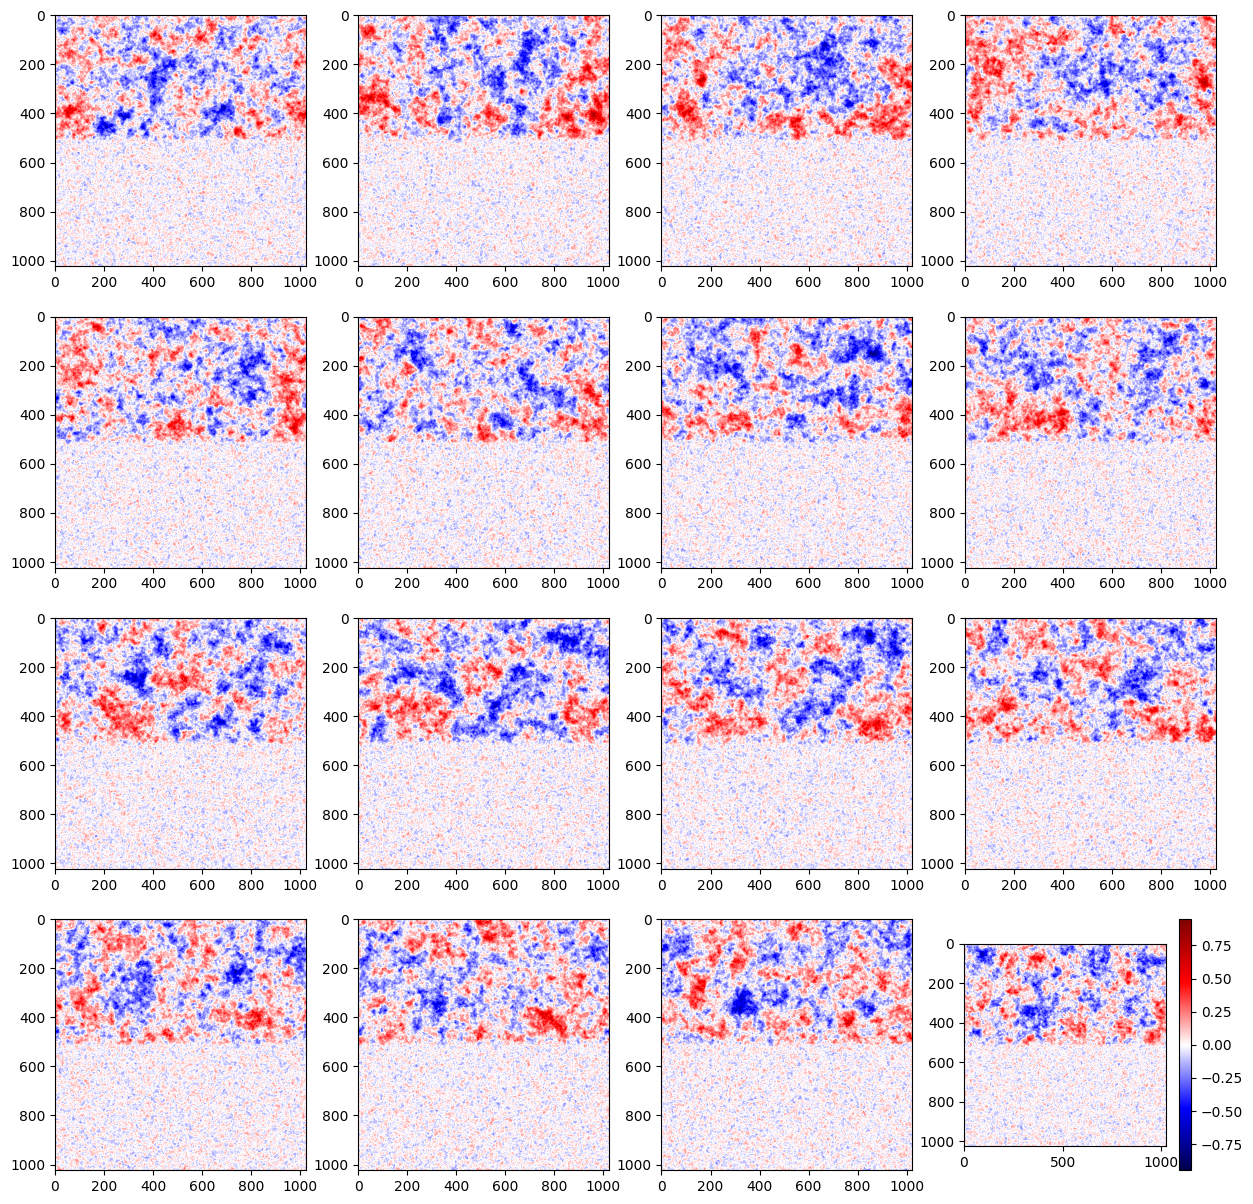

In [1648]:
v = torch.abs(x[0]).max()
plt.figure(figsize = (15, 15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x[i].view(N, N).cpu(), vmin = -v, vmax = v, cmap = 'seismic')
plt.colorbar()